# A1
## Group 8
**Submitted by: ZHANG Zhiyuan, zhizhan@student.chalmers.se** <br />
**Submitted by: LI Chenzhao, chenzhao@chalmers.se** <br />

# Task 0

In [4]:
# !python --version
# !which -a python
# !which -a pip
# %pip install pandas scikit-learn numpy matplotlib seaborn

In [5]:
# import os
# os.getcwd()

In [6]:
from abc import ABC, abstractmethod
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from graphviz import Digraph
from sklearn import preprocessing
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.base import ClassifierMixin
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# Task 1

## Step 1 Load the data

In [7]:
# Read the CSV file.
data = pd.read_csv("./A1_CTG.csv", skiprows=1)

# Select the relevant numerical columns.
selected_cols = ['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV',
                 'MLTV', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean',
                 'Median', 'Variance', 'Tendency', 'NSP']
data = data[selected_cols].dropna()

# Shuffle the dataset.
data_shuffled = data.sample(frac=1.0, random_state=0)

# Split into input part X and output part Y.
X = data_shuffled.drop('NSP', axis=1)


# Map the diagnosis code to a human-readable label.
def to_label(y):
    return [None, 'normal', 'suspect', 'pathologic'][(int(y))]


Y = data_shuffled['NSP'].apply(to_label)

# Partition the data into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

In [8]:
X.head(3)

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
658,130.0,1.0,0.0,3.0,0.0,0.0,0.0,24.0,1.2,12.0,...,35.0,120.0,155.0,1.0,0.0,134.0,133.0,135.0,1.0,0.0
1734,134.0,9.0,1.0,8.0,5.0,0.0,0.0,59.0,1.2,0.0,...,109.0,80.0,189.0,6.0,0.0,150.0,146.0,150.0,33.0,0.0
1226,125.0,1.0,0.0,4.0,0.0,0.0,0.0,43.0,0.7,31.0,...,21.0,120.0,141.0,0.0,0.0,131.0,130.0,132.0,1.0,0.0


22


<Axes: title={'center': 'Correlation Matrix'}>

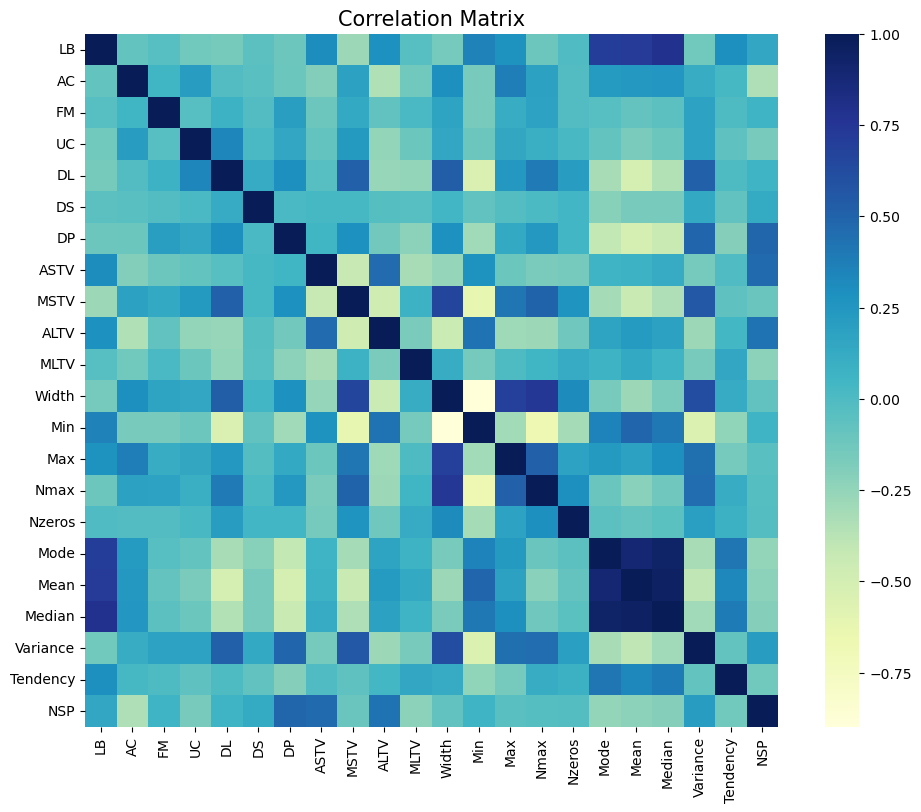

In [9]:
print(len(data.columns))
corrmat = data.corr()
plt.subplots(figsize=(12, 9))
plt.title('Correlation Matrix', fontsize=15)
sns.heatmap(corrmat, square=True, cmap="YlGnBu")

We notice that 3 columns, namely Mean, Median, and Mode have high correlation with each other. 

## Step 2

### Baseline

In [10]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy='most_frequent')

In [11]:
cross_val_score(clf, Xtrain, Ytrain).mean()

0.7805882352941176

## Step 3

In [12]:
DTree = DecisionTreeClassifier()
RForest = RandomForestClassifier()
GBoost = GradientBoostingClassifier()

DTree.fit(Xtrain, Ytrain)
RForest.fit(Xtrain, Ytrain)
GBoost.fit(Xtrain, Ytrain)

DTree_score = cross_val_score(DTree, Xtrain, Ytrain).mean()
RForest_score = cross_val_score(RForest, Xtrain, Ytrain).mean()
GBoost_score = cross_val_score(GBoost, Xtrain, Ytrain).mean()

print("Decision Tree:", DTree_score)
print("Random Forest:", RForest_score)
print("Gradient Boosting:", GBoost_score)

Decision Tree: 0.9211764705882353
Random Forest: 0.9364705882352942
Gradient Boosting: 0.95


### MLP performs better after scaling the data.

In [13]:
scaler = preprocessing.MinMaxScaler().fit(Xtrain)
X_scaled = scaler.transform(Xtrain)

In [14]:
mlp = MLPClassifier(hidden_layer_sizes=(15, 10, 6), max_iter=2000, random_state=0, solver='adam', activation='relu',
                    alpha=0.0001, learning_rate='adaptive')
mlp.fit(X_scaled, Ytrain)
mlp_score = cross_val_score(mlp, X_scaled, Ytrain).mean()
print("MLP Score:", mlp_score)

MLP Score: 0.9041176470588235


## Step 4

In [15]:
GBoost.fit(Xtrain, Ytrain)
Yguess = GBoost.predict(Xtest)
print(accuracy_score(Ytest, Yguess))

0.9295774647887324


# Task 2: Decision trees for classification
See `Lecture 1_pre.ipynb` fine-tune section

In [16]:
class DecisionTreeBranch:
    def __init__(self, feature, threshold, low_subtree, high_subtree):
        self.feature = feature
        self.threshold = threshold
        self.low_subtree = low_subtree
        self.high_subtree = high_subtree

    # For a branch node, we compute the prediction by first considering the feature, and then 
    # calling the upper or lower subtree, depending on whether the feature is or isn't greater
    # than the threshold.
    def predict(self, x):
        if x[self.feature] <= self.threshold:
            return self.low_subtree.predict(x)
        else:
            return self.high_subtree.predict(x)

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_counter, low_id = self.low_subtree.draw_tree(graph, node_counter, names)
        node_counter, high_id = self.high_subtree.draw_tree(graph, node_counter, names)
        node_id = str(node_counter)
        fname = f'F{self.feature}' if names is None else names[self.feature]
        lbl = f'{fname} > {self.threshold:.4g}?'
        graph.node(node_id, lbl, shape='box', fillcolor='yellow', style='filled, rounded')
        graph.edge(node_id, low_id, 'False')
        graph.edge(node_id, high_id, 'True')
        return node_counter + 1, node_id


In [17]:
class DecisionTreeLeaf:
    def __init__(self, value):
        self.value = value

    # This method computes the prediction for this leaf node. This will just return a constant value.
    def predict(self, x):
        return self.value

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_id = str(node_counter)
        val_str = f'{self.value:.4g}' if isinstance(self.value, float) else str(self.value)
        graph.node(node_id, val_str, style='filled')
        return node_counter + 1, node_id

    def __eq__(self, other):
        if isinstance(other, DecisionTreeLeaf):
            return self.value == other.value
        else:
            return False

In [18]:
class DecisionTree(ABC, BaseEstimator):
    def __init__(self, max_depth):
        super().__init__()
        self.max_depth = max_depth

    # As usual in scikit-learn, the training method is called *fit*. We first process the dataset so that
    # we're sure that it's represented as a NumPy matrix. Then we call the recursive tree-building method
    # called make_tree (see below).
    def fit(self, X, Y):
        if isinstance(X, pd.DataFrame):
            self.names = X.columns
            X = X.to_numpy()
        elif isinstance(X, list):
            self.names = None
            X = np.array(X)
        else:
            self.names = None
        Y = np.array(Y)
        self.root = self.make_tree(X, Y, self.max_depth)

    def draw_tree(self):
        graph = Digraph()
        self.root.draw_tree(graph, 0, self.names)
        return graph

    # By scikit-learn convention, the method *predict* computes the classification or regression output
    # for a set of instances.
    # To implement it, we call a separate method that carries out the prediction for one instance.
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        return [self.predict_one(x) for x in X]

    # Predicting the output for one instance.
    def predict_one(self, x):
        return self.root.predict(x)

        # This is the recursive training

    def make_tree(self, X, Y, max_depth):

        # We start by computing the default value that will be used if we'll return a leaf node.
        # For classifiers, this will be the most common value in Y.
        default_value = self.get_default_value(Y)

        # First the two base cases in the recursion: is the training set completely
        # homogeneous, or have we reached the maximum depth? Then we need to return a leaf.

        # If we have reached the maximum depth, return a leaf with the majority value.
        if max_depth == 0:
            return DecisionTreeLeaf(default_value)

        # If all the instances in the remaining training set have the same output value,
        # return a leaf with this value.
        if self.is_homogeneous(Y):
            return DecisionTreeLeaf(default_value)

        # Select the "most useful" feature and split threshold. To rank the "usefulness" of features,
        # we use one of the classification or regression criteria.
        # For each feature, we call best_split (defined in a subclass). We then maximize over the features.
        n_features = X.shape[1]
        _, best_feature, best_threshold = max(self.best_split(X, Y, feature) for feature in range(n_features))

        if best_feature is None:
            return DecisionTreeLeaf(default_value)

        # Split the training set into subgroups, based on whether the selected feature is greater than
        # the threshold or not
        X_low, X_high, Y_low, Y_high = self.split_by_feature(X, Y, best_feature, best_threshold)

        # Build the subtrees using a recursive call. Each subtree is associated
        # with a value of the feature.
        low_subtree = self.make_tree(X_low, Y_low, max_depth - 1)
        high_subtree = self.make_tree(X_high, Y_high, max_depth - 1)

        if low_subtree == high_subtree:
            return low_subtree

        # Return a decision tree branch containing the result.
        return DecisionTreeBranch(best_feature, best_threshold, low_subtree, high_subtree)

    # Utility method that splits the data into the "upper" and "lower" part, based on a feature
    # and a threshold.
    def split_by_feature(self, X, Y, feature, threshold):
        low = X[:, feature] <= threshold
        high = ~low
        return X[low], X[high], Y[low], Y[high]

    # The following three methods need to be implemented by the classification and regression subclasses.

    @abstractmethod
    def get_default_value(self, Y):
        pass

    @abstractmethod
    def is_homogeneous(self, Y):
        pass

    @abstractmethod
    def best_split(self, X, Y, feature):
        pass

In [19]:
def majority_sum_scorer(n_low, low_distr, n_high, high_distr):
    maj_sum_low = low_distr.most_common(1)[0][1]
    maj_sum_high = high_distr.most_common(1)[0][1]
    return maj_sum_low + maj_sum_high


def entropy(distr):
    n = sum(distr.values())
    ps = [n_i / n for n_i in distr.values()]
    return -sum(p * np.log2(p) if p > 0 else 0 for p in ps)


def info_gain_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low * entropy(low_distr) + n_high * entropy(high_distr)) / (n_low + n_high)


def gini_impurity(distr):
    n = sum(distr.values())
    ps = [n_i / n for n_i in distr.values()]
    return 1 - sum(p ** 2 for p in ps)


def gini_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low * gini_impurity(low_distr) + n_high * gini_impurity(high_distr)) / (n_low + n_high)

In [20]:
class TreeClassifier(DecisionTree, ClassifierMixin):

    def __init__(self, max_depth=10, criterion='maj_sum'):
        super().__init__(max_depth)
        self.criterion = criterion

    def fit(self, X, Y):
        # For decision tree classifiers, there are some different ways to measure
        # the homogeneity of subsets.
        if self.criterion == 'maj_sum':
            self.criterion_function = majority_sum_scorer
        elif self.criterion == 'info_gain':
            self.criterion_function = info_gain_scorer
        elif self.criterion == 'gini':
            self.criterion_function = gini_scorer
        else:
            raise Exception(f'Unknown criterion: {self.criterion}')
        super().fit(X, Y)
        self.classes_ = sorted(set(Y))

    # Select a default value that is going to be used if we decide to make a leaf.
    # We will select the most common value.
    def get_default_value(self, Y):
        self.class_distribution = Counter(Y)
        return self.class_distribution.most_common(1)[0][0]

    # Checks whether a set of output values is homogeneous. In the classification case, 
    # this means that all output values are identical.
    # We assume that we called get_default_value just before, so that we can access
    # the class_distribution attribute. If the class distribution contains just one item,
    # this means that the set is homogeneous.
    def is_homogeneous(self, Y):
        return len(self.class_distribution) == 1

    # Finds the best splitting point for a given feature. We'll keep frequency tables (Counters)
    # for the upper and lower parts, and then compute the impurity criterion using these tables.
    # In the end, we return a triple consisting of
    # - the best score we found, according to the criterion we're using
    # - the id of the feature
    # - the threshold for the best split
    def best_split(self, X, Y, feature):

        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        sorted_indices = np.argsort(X[:, feature])
        X_sorted = list(X[sorted_indices, feature])
        Y_sorted = list(Y[sorted_indices])

        n = len(Y)

        # The frequency tables corresponding to the parts *before and including*
        # and *after* the current element.
        low_distr = Counter()
        high_distr = Counter(Y)

        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None

        # Go through all the positions (excluding the last position).
        for i in range(0, n - 1):

            # Input and output at the current position.
            x_i = X_sorted[i]
            y_i = Y_sorted[i]

            # Update the frequency tables.
            low_distr[y_i] += 1
            high_distr[y_i] -= 1

            # If the input is equal to the input at the next position, we will
            # not consider a split here.
            #x_next = XY[i+1][0]
            x_next = X_sorted[i + 1]
            if x_i == x_next:
                continue

            # Compute the homogeneity criterion for a split at this position.
            score = self.criterion_function(i + 1, low_distr, n - i - 1, high_distr)

            # If this is the best split, remember it.
            if score > max_score:
                max_score = score
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5 * (X_sorted[max_i] + X_sorted[max_i + 1])
        return max_score, feature, split_point


0.8875846451256558


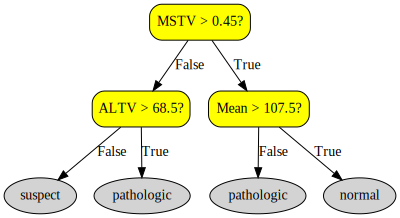

In [21]:
import numpy as np

cls = TreeClassifier(max_depth=2)
# cls.fit(X2, Y)
cls.fit(X, Y)

print(cross_val_score(cls, X, Y, cv=5).mean())

cls.draw_tree()

0.9087478597072632


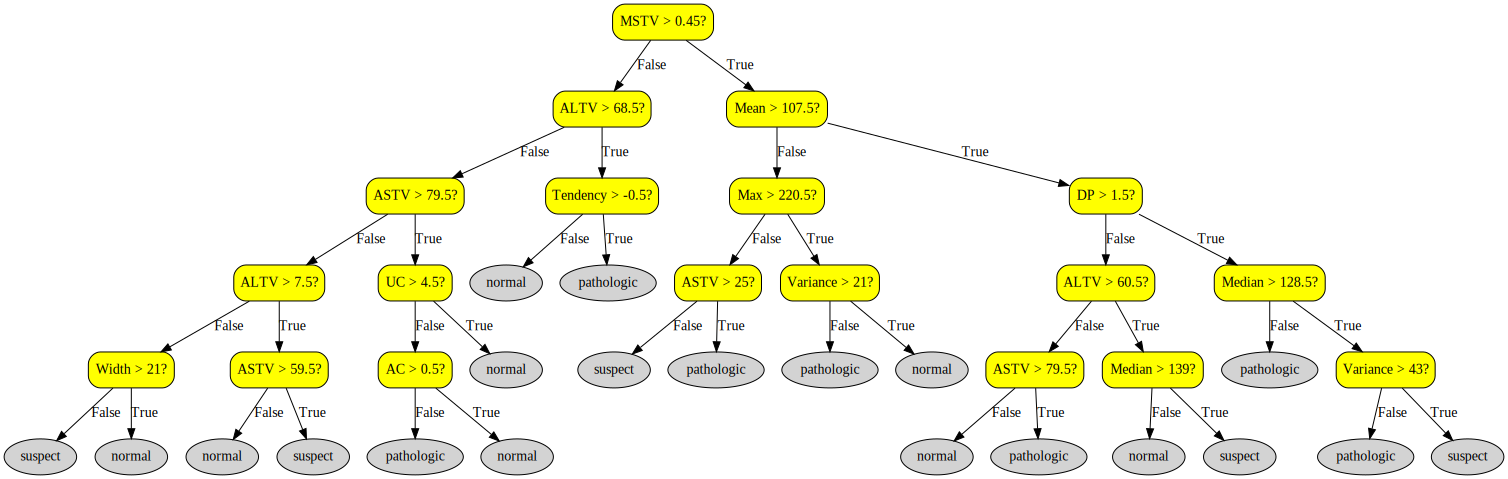

In [22]:
cls5 = TreeClassifier(max_depth=5)
cls5.fit(X, Y)

print(cross_val_score(cls5, X, Y, cv=5).mean())

cls5.draw_tree()

0.9101552057442694


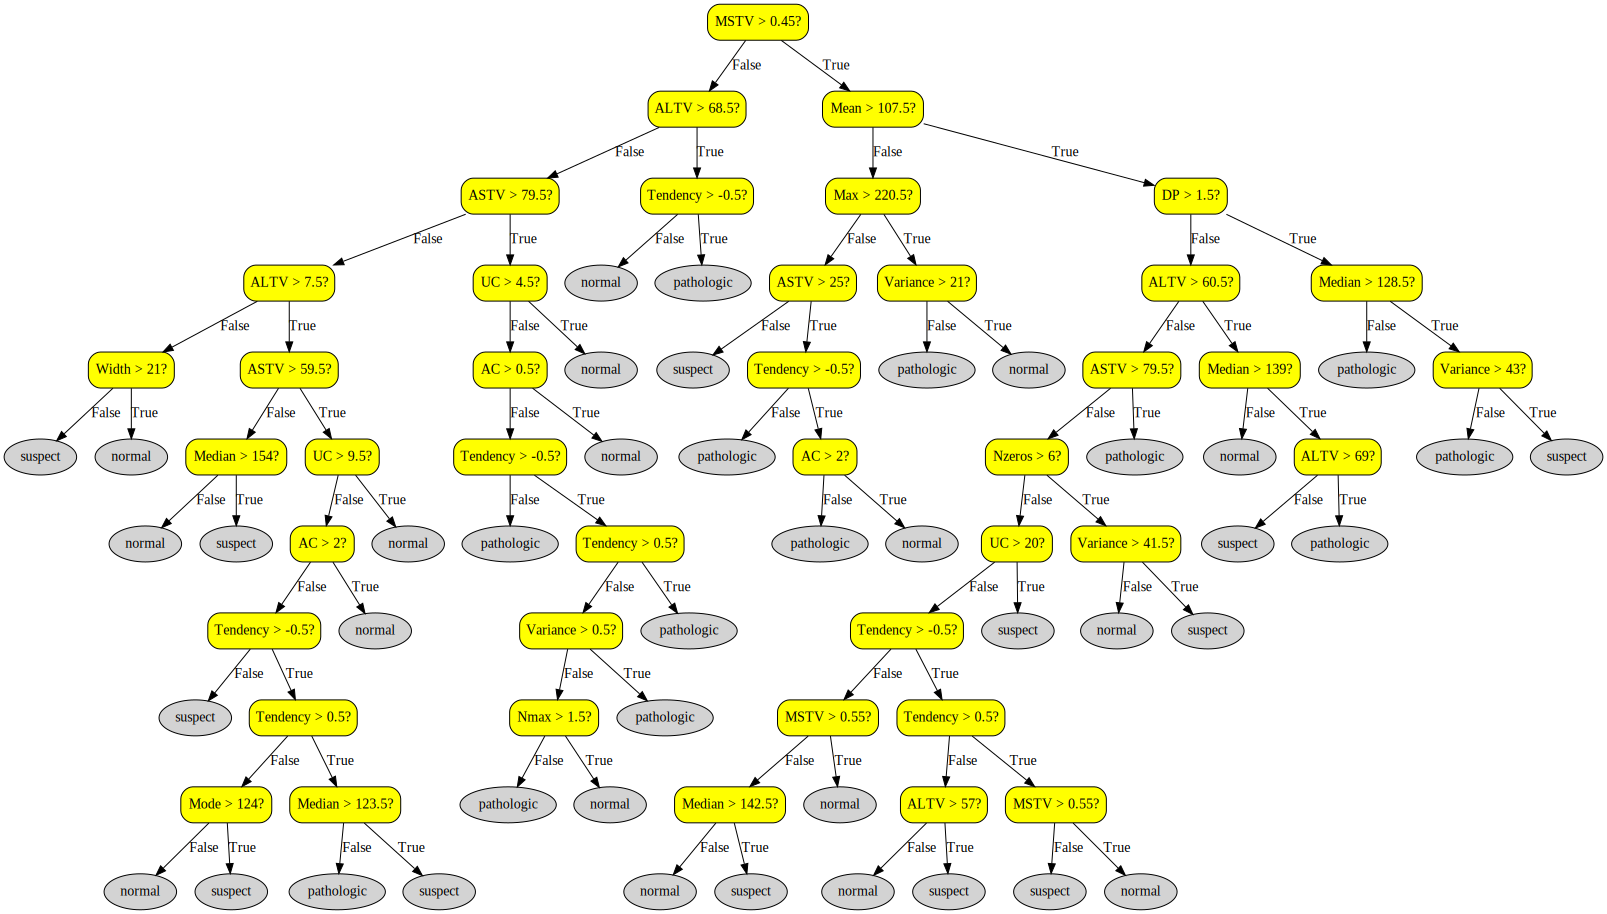

In [23]:
cls10 = TreeClassifier(max_depth=10)
cls10.fit(X, Y)

print(cross_val_score(cls10, X, Y, cv=5).mean())

cls10.draw_tree()

In [24]:
cls12 = TreeClassifier(max_depth=12)
cls12.fit(X, Y)

print(cross_val_score(cls12, X, Y, cv=5).mean())

0.912039768019884


0.9063938138635736


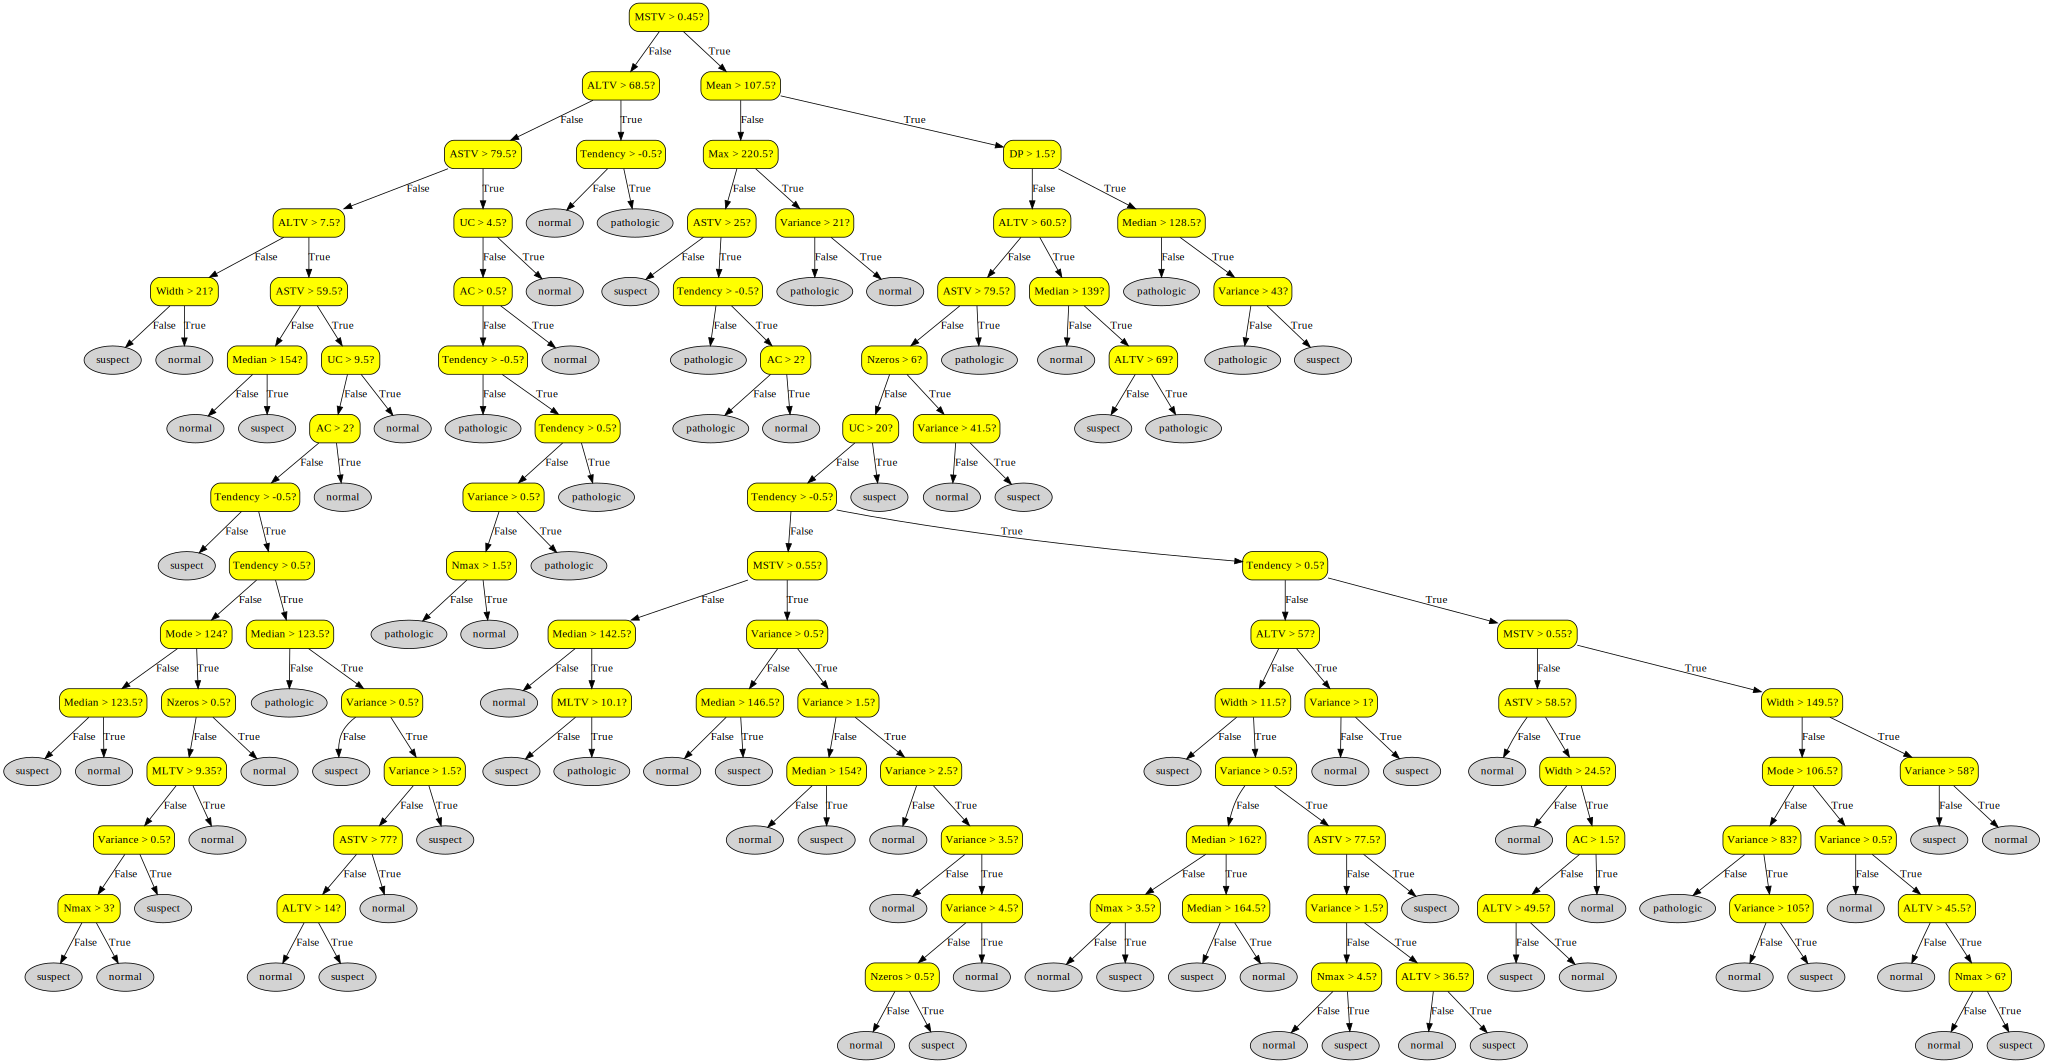

In [25]:
cls15 = TreeClassifier(max_depth=15)
cls15.fit(X, Y)

print(cross_val_score(cls15, X, Y, cv=5).mean())

cls15.draw_tree()

# Task 3: A regression example

In [26]:
alldata = pd.read_csv("./A1_sberbank.csv")


# Convert the timestamp string to an integer representing the year.
def get_year(timestamp):
    return int(timestamp[:4])


alldata['year'] = alldata.timestamp.apply(get_year)

# Select the 9 input columns and the output column.
selected_columns = ['price_doc', 'year', 'full_sq', 'life_sq', 'floor', 'num_room', 'kitch_sq', 'full_all']
alldata = alldata[selected_columns]
alldata = alldata.dropna()

# Shuffle.
alldata_shuffled = alldata.sample(frac=1.0, random_state=0)

# Separate the input and output columns.
X_bank = alldata_shuffled.drop('price_doc', axis=1)
# For the output, we'll use the log of the sales price.
Y_bank = alldata_shuffled['price_doc'].apply(np.log)

# Split into training and test sets.
Xtrain_bank, Xtest_bank, Ytrain_bank, Ytest_bank = train_test_split(X_bank, Y_bank, test_size=0.2, random_state=0)

# Scale the input
scaler = preprocessing.MinMaxScaler().fit(Xtrain_bank)
X_scaled_bank = scaler.transform(Xtrain_bank)
Xtest_scaled_bank = scaler.transform(Xtest_bank)

In [27]:
Ytest_bank.head(3)

24987    15.598902
12766    15.464169
22648    15.789592
Name: price_doc, dtype: float64

In [28]:
Xtest_bank.columns

Index(['year', 'full_sq', 'life_sq', 'floor', 'num_room', 'kitch_sq',
       'full_all'],
      dtype='object')

In [29]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate

m1 = DummyRegressor()
cross_validate(m1, Xtrain_bank, Ytrain_bank, scoring='neg_mean_squared_error')

{'fit_time': array([0.        , 0.        , 0.00800133, 0.        , 0.        ]),
 'score_time': array([0., 0., 0., 0., 0.]),
 'test_score': array([-0.39897319, -0.37113485, -0.38083108, -0.39057156, -0.40475168])}

In [30]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_scaled_bank, Ytrain_bank)

# Ridge Regression
ridge = Ridge()
ridge.fit(X_scaled_bank, Ytrain_bank)

# Lasso Regression
lasso = Lasso()
lasso.fit(X_scaled_bank, Ytrain_bank)

# Decision Tree Regressor
dt = DecisionTreeRegressor()
dt.fit(X_scaled_bank, Ytrain_bank)

# Random Forest Regressor
rf = RandomForestRegressor()
rf.fit(X_scaled_bank, Ytrain_bank)

# Gradient Boosting Regressor
gb = GradientBoostingRegressor()
gb.fit(X_scaled_bank, Ytrain_bank)

# MLP Regressor
mlp = MLPRegressor()
mlp.fit(X_scaled_bank, Ytrain_bank)

# Cross-validation
lr_score = cross_validate(lr, X_scaled_bank, Ytrain_bank, scoring='neg_mean_squared_error')["test_score"].mean()
ridge_score = cross_validate(ridge, X_scaled_bank, Ytrain_bank, scoring='neg_mean_squared_error')["test_score"].mean()
lasso_score = cross_validate(lasso, X_scaled_bank, Ytrain_bank, scoring='neg_mean_squared_error')["test_score"].mean()
dt_score = cross_validate(dt, X_scaled_bank, Ytrain_bank, scoring='neg_mean_squared_error')["test_score"].mean()
rf_score = cross_validate(rf, X_scaled_bank, Ytrain_bank, scoring='neg_mean_squared_error')["test_score"].mean()
gb_score = cross_validate(gb, X_scaled_bank, Ytrain_bank, scoring='neg_mean_squared_error')["test_score"].mean()
mlp_score = cross_validate(mlp, X_scaled_bank, Ytrain_bank, scoring='neg_mean_squared_error')["test_score"].mean()

print("Linear Regression:", lr_score)
print("Ridge Regression:", ridge_score)
print("Lasso Regression:", lasso_score)
print("Decision Tree Regressor:", dt_score)
print("Random Forest Regressor:", rf_score)
print("Gradient Boosting Regressor:", gb_score)
print("MLP Regressor:", mlp_score)

Linear Regression: -0.30139865887671535
Ridge Regression: -0.2942222867434697
Lasso Regression: -0.38925247260237567
Decision Tree Regressor: -0.5291224509533423
Random Forest Regressor: -0.28336886344309486
Gradient Boosting Regressor: -0.26457898187294127
MLP Regressor: -0.2905767434683239


### Smaller MSE == better performance

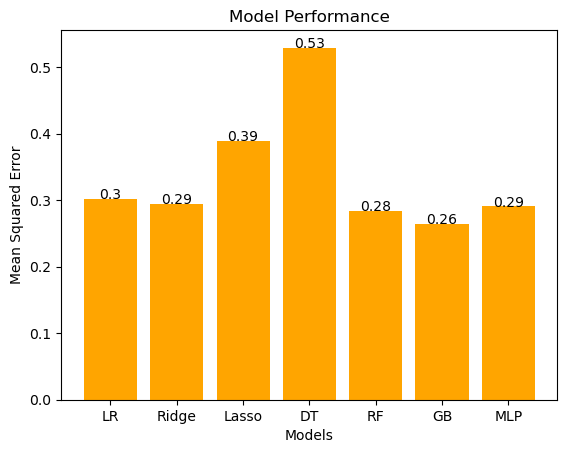

In [31]:
# Assuming the scores are negative mean squared errors, we take the negative of the scores to get the MSE.
scores = [-lr_score, -ridge_score, -lasso_score, -dt_score, -rf_score, -gb_score, -mlp_score]
labels = ['LR', 'Ridge', 'Lasso', 'DT', 'RF', 'GB', 'MLP']

for i in range(len(scores)):
    plt.text(i, scores[i], round(scores[i], 2), ha='center')

plt.bar(labels, scores, color='orange')
plt.xlabel('Models')
plt.ylabel('Mean Squared Error')
plt.title('Model Performance')
plt.show()


In [32]:
print("1. Linear Regression\t\t", mean_squared_error(Ytest_bank, lr.predict(Xtest_scaled_bank)))
print("2. Ridge Regression\t\t", mean_squared_error(Ytest_bank, ridge.predict(Xtest_scaled_bank)))
print("3. Lasso Regression\t\t", mean_squared_error(Ytest_bank, lasso.predict(Xtest_scaled_bank)))
print("4. Decision Tree Regressor\t", mean_squared_error(Ytest_bank, dt.predict(Xtest_scaled_bank)))
print("5. Random Forest Regressor\t", mean_squared_error(Ytest_bank, rf.predict(Xtest_scaled_bank)))
print("6. Gradient Boosting Regressor\t", mean_squared_error(Ytest_bank, gb.predict(Xtest_scaled_bank)))
print("7. MLP Regressor\t\t", mean_squared_error(Ytest_bank, mlp.predict(Xtest_scaled_bank)))

1. Linear Regression		 0.315589039700377
2. Ridge Regression		 0.3147315649726388
3. Lasso Regression		 0.4028398414133475
4. Decision Tree Regressor	 0.5679140387249777
5. Random Forest Regressor	 0.2987366990662265
6. Gradient Boosting Regressor	 0.27142939334239424
7. MLP Regressor		 0.3142667523510713


### Best performing model is Gradient Boosting Regressor with a mean squared error of 0.27 on the test set.

# Task 4: Decision trees for regression

## Step 1

In [33]:
class TreeRegressor(DecisionTree, RegressorMixin):

    def __init__(self, max_depth=10, criterion='variance_reduction'):
        super().__init__(max_depth)
        self.criterion = criterion

    def fit(self, X, Y):
        if self.criterion == 'variance_reduction':
            self.criterion_function = self.variance_reduction_scorer
        else:
            raise Exception(f'Unknown criterion: {self.criterion}')
        super().fit(X, Y)

    def get_default_value(self, Y):
        return np.mean(Y)

    def is_homogeneous(self, Y):
        # return len(self.class_distribution) == 1
        # return np.var(Y) < 0.5  # This threshold can be adjusted
        return np.max(np.abs(Y - np.mean(Y))) < 1e-5

    def variance_reduction_scorer(self, nH, low_distr, nL, high_distr):
        V_S = np.var(list(low_distr.elements()) + list(high_distr.elements()))
        V_SH = np.var(list(high_distr.elements()))
        V_SL = np.var(list(low_distr.elements()))
        return V_S - nH * V_SH / (nH + nL) - nL * V_SL / (nH + nL)

    def best_split(self, X, Y, feature):
        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        sorted_indices = np.argsort(X[:, feature])
        X_sorted = list(X[sorted_indices, feature])
        Y_sorted = list(Y[sorted_indices])

        n = len(Y)

        # The frequency tables corresponding to the parts *before and including*
        # and *after* the current element.
        low_distr = Counter()
        high_distr = Counter(Y)

        # Keep track of the best result we've seen so far.
        min_score = np.inf
        min_i = None

        # Go through all the positions (excluding the last position).
        for i in range(0, n - 1):

            # Input and output at the current position.
            x_i = X_sorted[i]
            y_i = Y_sorted[i]

            # Update the frequency tables.
            low_distr[y_i] += 1
            high_distr[y_i] -= 1

            # If the input is equal to the input at the next position, we will
            # not consider a split here.
            x_next = X_sorted[i + 1]
            if x_i == x_next:
                continue

            # Compute the homogeneity criterion for a split at this position.
            score = self.criterion_function(i + 1, low_distr, n - i - 1, high_distr)

            # If this is the best split, remember it.
            if score < min_score:
                min_score = score
                min_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if min_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5 * (X_sorted[min_i] + X_sorted[min_i + 1])
        return min_score, feature, split_point


0.022307299292579397


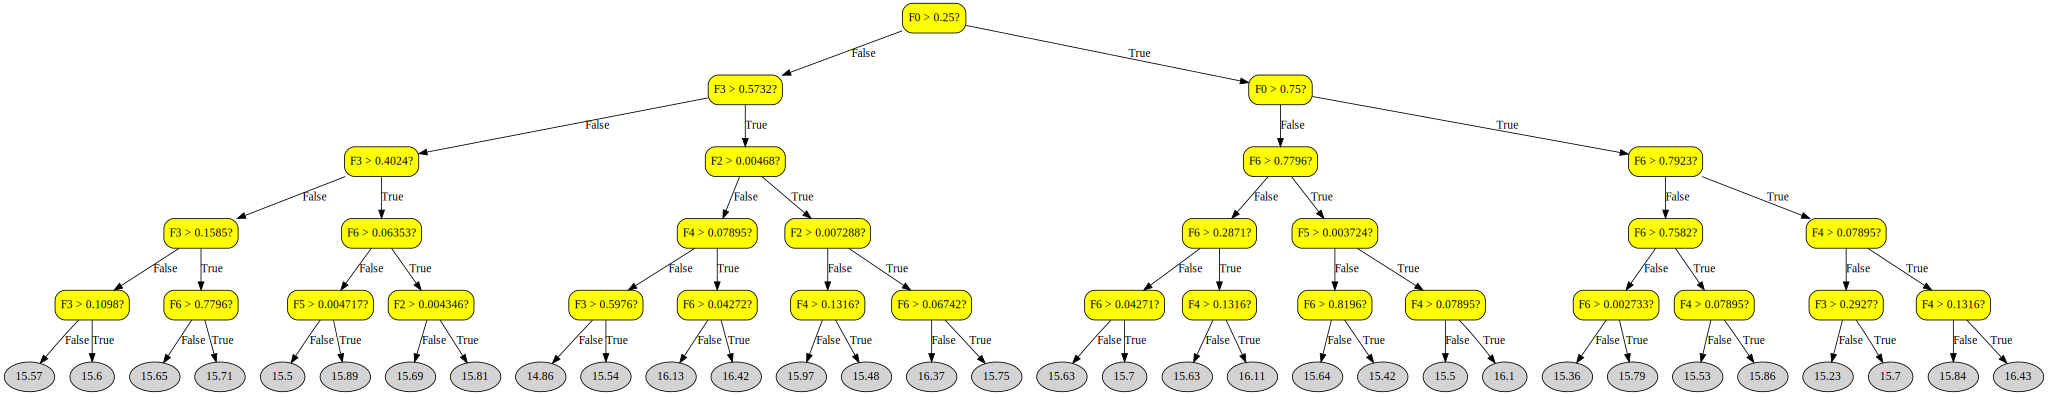

In [34]:
cls = TreeRegressor(max_depth=5)
cls.fit(X_scaled_bank, Ytrain_bank)

print(cross_val_score(cls, X_scaled_bank, Ytrain_bank, cv=5).mean())

cls.draw_tree()

## Step 2 Sanity check

In [35]:
def make_some_data(n):
    x = np.random.uniform(-5, 5, size=n)
    Y = (x > 1) + 0.1 * np.random.normal(size=n)
    X = x.reshape(n, 1)  # X needs to be a 2-dimensional matrix
    return X, Y

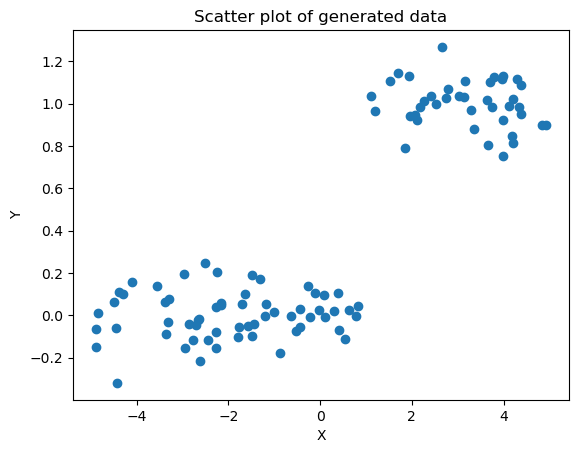

In [36]:
# Generate the data
X_fake, Y_fake = make_some_data(100)

# Create a scatter plot
plt.scatter(X_fake, Y_fake)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter plot of generated data')
plt.show()


0.7352849788437426


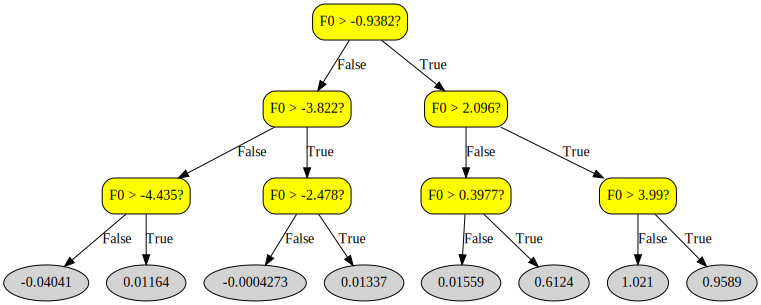

In [37]:
TR_fake = TreeRegressor(max_depth=3)
TR_fake.fit(X_fake, Y_fake)

print(cross_val_score(TR_fake, X_fake, Y_fake, cv=5).mean())

TR_fake.draw_tree()

### Allow the tree depth to be a large number
We set the value of `max_depth` to be 30. We believe that `TR_fake1` overfits the data we generated using `make_some_data`. 

0.8606935709951344


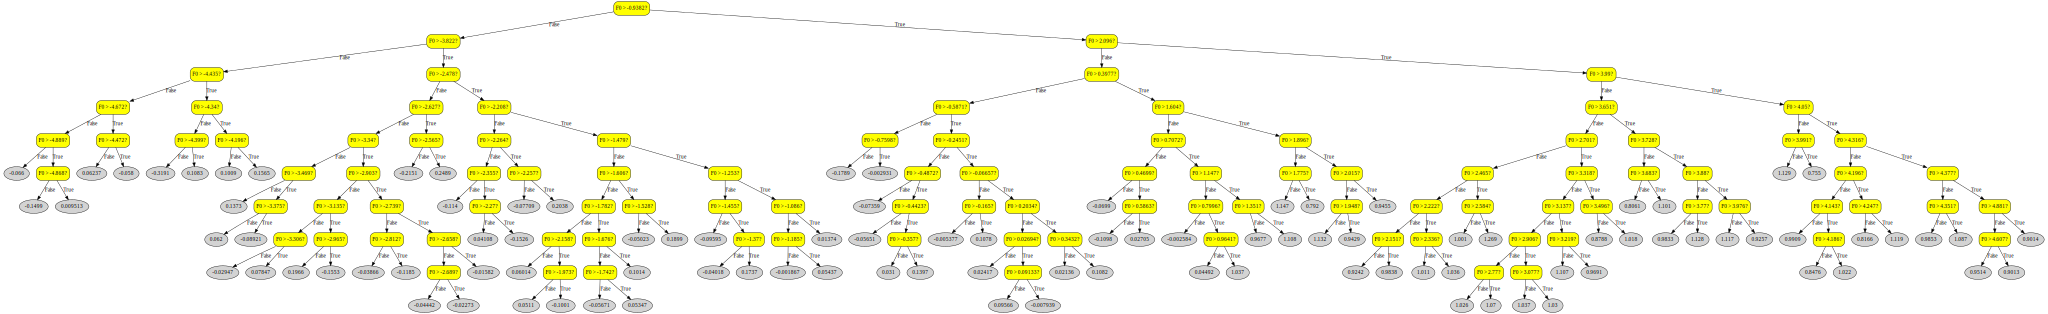

In [38]:
TR_fake1 = TreeRegressor(max_depth=30)
TR_fake1.fit(X_fake, Y_fake)

print(cross_val_score(TR_fake1, X_fake, Y_fake, cv=5).mean())

TR_fake1.draw_tree()

## Step 3. Predict Price using decision tree regression

In [39]:
OurTR = TreeRegressor(max_depth=12)
OurTR.fit(X_scaled_bank, Ytrain_bank)

print("max_depth=12:", mean_squared_error(Ytest_bank, OurTR.predict(Xtest_scaled_bank)))

max_depth=12: 0.3578209538072266


## Step 4. Underfitting and overfitting

In [46]:
# for i in range(12):
#     TR = TreeRegressor(max_depth=i)
#     TR.fit(X_scaled_bank, Ytrain_bank)

#     print(i + 1, mean_squared_error(Ytest_bank, TR.predict(Xtest_scaled_bank)))
scores_bank = []
s_train = []
for i in range(12):
    TR = TreeRegressor(max_depth=i)
    TR.fit(X_scaled_bank, Ytrain_bank)
    s_train.append(mean_squared_error(Ytrain_bank, TR.predict(X_scaled_bank)))
    s_test = mean_squared_error(Ytest_bank, TR.predict(Xtest_scaled_bank))
    scores_bank.append(s_test)
    print(i + 1, s_test)

1 0.4028398414133475
2 0.4022687816490513
3 0.40107314862520377
4 0.40149345187426455
5 0.3987169195771907
6 0.3953693377307609
7 0.3950794063741335
8 0.3888866917354355
9 0.3832834171785428
10 0.37694835932989346
11 0.36821403276385484
12 0.35722366437279673


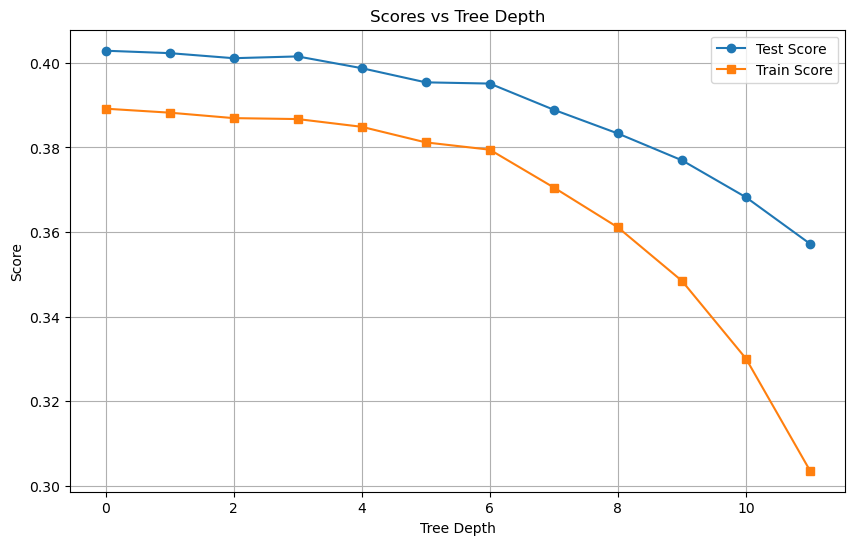

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(scores_bank, 'o-', label='Test Score')  # 'o-' means that the points will be marked and connected by a line
plt.plot(s_train, 's-', label='Train Score')  # 's-' means that the points will be marked and connected by a line

plt.xlabel('Tree Depth')
plt.ylabel('Score')
plt.title('Scores vs Tree Depth')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
TR = TreeRegressor(max_depth=15)
TR.fit(X_scaled_bank, Ytrain_bank)

print("max_depth=15:", mean_squared_error(Ytest_bank, TR.predict(Xtest_scaled_bank)))

max_depth=15: 0.38266941509938096


1 0.4028398414133475
2 0.4022687816490513
3 0.40107314862520377
4 0.40149345187426455
5 0.3987169195771907
6 0.3953693377307609
7 0.3950794063741335
8 0.3888866917354355
9 0.3832834171785428
10 0.37694835932989346
11 0.36821403276385484
12 0.35722366437279673
13 0.3578209538072266
14 0.3628994174532579
15 0.36366687175773005
16 0.38266941509938096
17 0.39506870824058116
18 0.4154260347790922
19 0.4339027822238936
20 0.4504645294338321


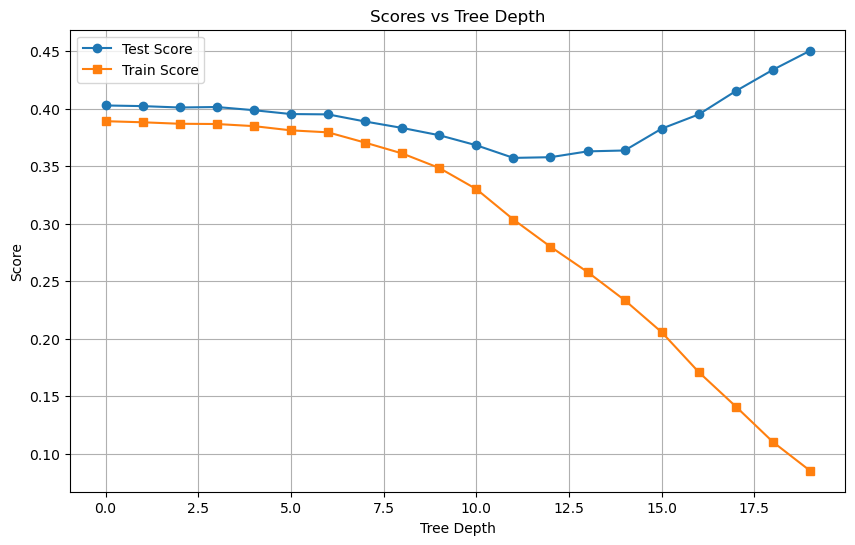

In [48]:
scores_bank = []
s_train = []
for i in range(20):
    TR = TreeRegressor(max_depth=i)
    TR.fit(X_scaled_bank, Ytrain_bank)
    s_train.append(mean_squared_error(Ytrain_bank, TR.predict(X_scaled_bank)))
    s_test = mean_squared_error(Ytest_bank, TR.predict(Xtest_scaled_bank))
    scores_bank.append(s_test)
    print(i + 1, s_test)

plt.figure(figsize=(10, 6))
plt.plot(scores_bank, 'o-', label='Test Score')  # 'o-' means that the points will be marked and connected by a line
plt.plot(s_train, 's-', label='Train Score')  # 's-' means that the points will be marked and connected by a line

plt.xlabel('Tree Depth')
plt.ylabel('Score')
plt.title('Scores vs Tree Depth')
plt.legend()
plt.grid(True)
plt.show()